# GALAXY-GALAXY LENSING ANGULAR POWER SPECTRA

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from astropy.cosmology import FlatLambdaCDM
from skypy.power_spectrum import growth_function

cosmo = FlatLambdaCDM(H0=67.5, Ob0=0.0483, Om0= 0.2678)

## 1. Matter power spectra

In [4]:
import sys
sys.path.append("../power/EdS")
from matter import matter_power_spectrum_1loop as P1loop
from matter import matter_unequal_time_power_spectrum as Puetc
sys.path.append("../analysis")
from power import geometric_approx_squared as PPgeom
from power import midpoint_approx as Pmid

* Linear power spectra

Use SkyPy here

In [5]:
import camb

In [6]:
x = np.linspace(0.1, 10000, 21)
k = np.logspace(-5, 3, 3072)
TINY = np.finfo(0.).tiny

In [7]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)

results = camb.get_background(pars)

z = results.redshift_at_comoving_radial_distance(x)
kh = k/(pars.H0/100)

pars.set_matter_power(redshifts=z, kmax=2*k[-1], nonlinear=True)
pars.set_for_lmax(2500, lens_potential_accuracy=4)

results = camb.get_results(pars)

kh, z, p = results.get_matter_power_spectrum(minkh=kh[0], maxkh=kh[-1], npoints=len(kh))
cl_lens = results.get_lens_potential_cls(2500)[:,0]

Note: redshifts have been re-sorted (earliest first)


In [8]:
np.allclose(kh*(pars.H0/100), k)

True

* One-loop power spectrum

In [9]:
d = np.loadtxt('../example/Pfastpt.txt',unpack=True)
ks, pk, p22, p13 = d[:, 0], d[:, 1], d[:, 2], d[:, 3]
p11_int = interp1d( ks, pk, fill_value="extrapolate")
# p11_int = interp1d( kh, p[0], fill_value="extrapolate")
p22_int = interp1d( ks, p22, fill_value="extrapolate")
p13_int = interp1d( ks, p13, fill_value="extrapolate")
powerk = (p11_int, p22_int, p13_int)

In [10]:
g = growth_function(np.asarray(z), cosmo)/growth_function(0, cosmo)

* Unequal-time power spectra

In [11]:
p = g[:, np.newaxis] * p11_int(k)
pgeom_linear = np.sqrt(p[:, None] * p[None, :])

In [12]:
pet = P1loop(k, g, powerk)
puet = Puetc(k, g, g, powerk)
pgeom = np.sqrt(PPgeom(k, g, g, powerk))
pmid = Pmid(k, g, g, powerk)

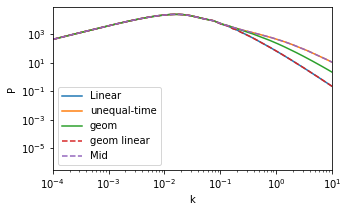

In [13]:
plt.figure(figsize=(5,3))
plt.loglog(k, p[0], label='Linear')
plt.loglog(k, puet[0][0], label='unequal-time')
plt.loglog(k, pgeom[0][0], label='geom')
plt.loglog(k, pgeom_linear[0][0], '--', label='geom linear')
plt.loglog(k, pmid[0][0], '--', label='Mid')
plt.xlabel('k')
plt.ylabel('P')
plt.xlim(1e-4, 1e1)
plt.legend()
plt.show()

## 2. The correlation function

In [14]:
sys.path.append("../../corfu")
import corfu

In [15]:
theta = np.logspace(-3, np.log10(np.pi), 400)

In [16]:
r_limb_linear, xi_limb_linear = corfu.ptoxi(k, p, q=0, limber=True)
r_geom_linear, xi_geom_linear = corfu.ptoxi(k, pgeom_linear, q=0)

In [17]:
r_uet, xi_uet = corfu.ptoxi(k, puet, q=0)
r_limb, xi_limb = corfu.ptoxi(k, pet, q=0, limber=True)
r_geom, xi_geom = corfu.ptoxi(k, pgeom, q=0)
r_mid, xi_mid = corfu.ptoxi(k, pmid, q=0)

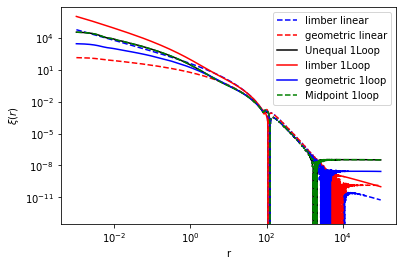

In [18]:
plt.loglog(r_limb_linear, +xi_limb_linear[0], '--b', label='limber linear')
plt.loglog(r_limb_linear, -xi_limb_linear[0], ':b')
plt.loglog(r_geom_linear, +xi_geom_linear[0,0], '--r', label='geometric linear')
plt.loglog(r_geom_linear, -xi_geom_linear[0,0], ':r')

plt.loglog(r_uet, +xi_uet[0,0], 'k', label='Unequal 1Loop')
plt.loglog(r_uet, -xi_uet[0,0], '--k')
plt.loglog(r_limb, +xi_limb[0], 'r', label='limber 1Loop')
plt.loglog(r_limb, -xi_limb[0], '--r')
plt.loglog(r_geom, +xi_geom[0,0], 'b', label='geometric 1loop')
plt.loglog(r_geom, -xi_geom[0,0], '--b')
plt.loglog(r_mid, +xi_mid[0,0], '--g', label='Midpoint 1loop')
plt.loglog(r_mid, -xi_mid[0,0], ':g')

plt.legend()
plt.xlabel('r')
plt.ylabel(r'$\xi(r)$')
plt.show()

## 3. Lensing filters

In [19]:
sys.path.append("../lensing")
from lens_filter import redshift_distribution_galaxies, filter_galaxy_clustering, lensing_efficiency, filter_convergence, filter_shear

In [94]:
chi = np.linspace(0, 2000, 500) # galaxy clustering
# chis = np.linspace(1e-10, 2000, 500) # shear

In [95]:
zchi = results.redshift_at_comoving_radial_distance(chi) # galaxy clustering
# zchis = results.redshift_at_comoving_radial_distance(chis) # shear

* Redshift distribution of galaxies

In [68]:
n1 = redshift_distribution_galaxies(chi, 1)
n2 = redshift_distribution_galaxies(chi, 2)

* Lensing efficiency

In [80]:
q1 = lensing_efficiency(chi, 1)
q2 = lensing_efficiency(chi, 2)

* Galaxy clustering

In [70]:
bias_LSST = [1.24, 1.36, 1.47, 1.60, 1.76]
bias_DESY1 = [1.44, 1.70, 1.70, 2.00, 2.06]
nobias = 1.0

In [71]:
fg1 = filter_galaxy_clustering(chi, zchi, n1, bias_DESY1[0], cosmo)
fg2 = filter_galaxy_clustering(chi, zchi, n2, bias_DESY1[0], cosmo)

* Shear

In [108]:
fs1 = filter_shear(chi, zchi, q1, cosmo)
fs2 = filter_shear(chi, zchi, q2, cosmo)

../lensing/lens_filter.py:177: RuntimeWarning: divide by zero encountered in true_divide
  return factor.value * (1.0 + zx) * lens_efficiency / x


In [112]:
fs1[fs1 == np.inf] = 0
fs2[fs2 == np.inf] = 0

## 4. Angular correlation function

* Galaxy galaxy lensing

In [113]:
w_limb_linear = corfu.eqt(theta, (chi, fg1*fs1), (x, r_limb_linear, xi_limb_linear))
w_geom_linear = corfu.uneqt(theta, (chi, fg1), (chi, fs1), (x, x, r_geom_linear, xi_geom_linear))

In [116]:
w_uet = corfu.uneqt(theta, (chi, fg1), (chi, fs1), (x, x, r_uet, xi_uet))

In [117]:
w_limb = corfu.eqt(theta, (chi, fg1*fs1), (x, r_limb, xi_limb))
w_geom = corfu.uneqt(theta, (chi, fg1), (chi, fs1), (x, x, r_geom, xi_geom))

In [118]:
w_mid = corfu.uneqt(theta, (chi, fg1), (chi, fs1), (x, x, r_mid, xi_mid))

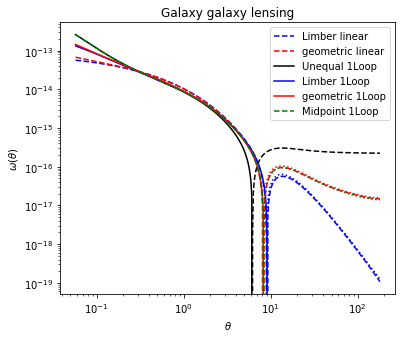

In [123]:
plt.figure(figsize=(6, 5))
plt.loglog(np.degrees(theta), +w_limb_linear, '--b', label='Limber linear')
plt.loglog(np.degrees(theta), -w_limb_linear, ':b')
plt.loglog(np.degrees(theta), +w_geom_linear, '--r', label='geometric linear')
plt.loglog(np.degrees(theta), -w_geom_linear, ':r')


plt.loglog(np.degrees(theta), +w_uet, 'k', label='Unequal 1Loop')
plt.loglog(np.degrees(theta), -w_uet, '--k')
plt.loglog(np.degrees(theta), +w_limb, 'b', label='Limber 1Loop')
plt.loglog(np.degrees(theta), -w_limb, '--b')
plt.loglog(np.degrees(theta), +w_geom, 'r', label='geometric 1Loop')
plt.loglog(np.degrees(theta), -w_geom, '--r')
plt.loglog(np.degrees(theta), +w_mid, '--g', label='Midpoint 1Loop')
plt.loglog(np.degrees(theta), -w_mid, ':g')
plt.legend()
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\omega(\theta)$')
plt.title('Galaxy galaxy lensing')
plt.savefig('../plots/gg_lensing_w.pdf')
plt.show()

## 5. Angular power spectra

* Galaxy galaxy lensing

In [124]:
l_limb_linear, cl_limb_linear = corfu.wtocl(theta, w_limb_linear, lmax=2000)
l_geom_linear, cl_geom_linear = corfu.wtocl(theta, w_geom_linear, lmax=2000)

In [120]:
l_uet, cl_uet = corfu.wtocl(theta, w_uet, lmax=2000)
l_limb, cl_limb = corfu.wtocl(theta, w_limb, lmax=2000)
l_geom, cl_geom = corfu.wtocl(theta, w_geom, lmax=2000)
l_mid, cl_mid = corfu.wtocl(theta, w_mid, lmax=2000)

In [121]:
ell = l_limb_linear
ell_factor = (ell +2) * (ell + 1) * ell * (ell -1)

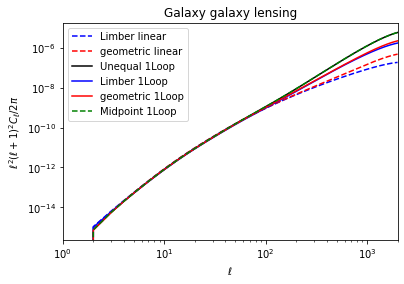

In [126]:
plt.loglog(ell_factor * cl_limb_linear, '--b', label='Limber linear')
plt.loglog(ell_factor * cl_geom_linear, '--r', label='geometric linear')
plt.loglog(ell_factor * cl_uet, 'k', label='Unequal 1Loop')
plt.loglog(ell_factor * cl_limb, 'b', label='Limber 1Loop')
plt.loglog(ell_factor * cl_geom, 'r', label='geometric 1Loop')
plt.loglog(ell_factor * cl_mid, '--g', label='Midpoint 1Loop')

plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^2(\ell+1)^2C_\ell/2\pi$')
plt.xlim([1,2000])
plt.title('Galaxy galaxy lensing')
plt.savefig('../plots/gg_lensing_cl.pdf')
plt.show()

## 6. Sanity check

In [72]:
w_fromcl_limb_linear = corfu.cltow(cl_limb_linear, theta)

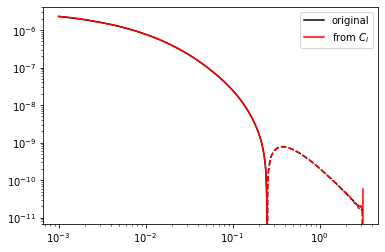

In [73]:
plt.loglog(theta, +w_limb_linear, 'k', label='original')
plt.loglog(theta, -w_limb_linear, '--k')
plt.loglog(theta, +w_fromcl_limb_linear, 'r', label='from $C_l$')
plt.loglog(theta, -w_fromcl_limb_linear, '--r')
plt.legend()
plt.show()

In [74]:
w_fromcl_limb = corfu.cltow(cl_limb, theta)

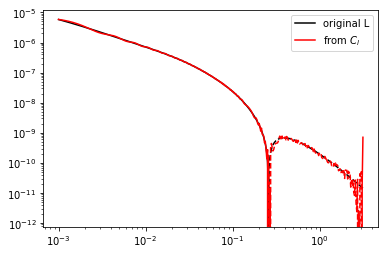

In [75]:
plt.loglog(theta, +w_limb, 'k', label='original L')
plt.loglog(theta, -w_limb, '--k')
plt.loglog(theta, +w_fromcl_limb, 'r', label='from $C_l$')
plt.loglog(theta, -w_fromcl_limb, '--r')
plt.legend()
plt.show()